In [1]:
import os
import pickle
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
# Precision, Recall, F1, and plot confusion matrix libs
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix

if torch.cuda.is_available():
    device = torch.device("cuda")
    num_gpus = torch.cuda.device_count()
    print(f"Using CUDA (GPU) Available GPUs: {num_gpus}")
    
    # 显示所有可用 GPU 设备信息
    for i in range(num_gpus):
        print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
else:
    device = torch.device("cpu")
    print("Using CPU (No GPU detected)")

# 显示最终选择的设备
print(f"Running on device: {device}")

Using CUDA (GPU) Available GPUs: 1
GPU 0: NVIDIA GeForce RTX 4080 SUPER
Running on device: cuda


In [2]:
# Read CIFAR-10 batch file
def load_cifar10_train(root_dir):
    all_data = []
    all_labels = []
    for i in range(1, 6):
        file_name = os.path.join(root_dir, f"data_batch_{i}")
        with open(file_name, 'rb') as fo:
            data_dict = pickle.load(fo, encoding='bytes')
            # data_dict[b'data'] shape: (10000, 3072)
            # data_dict[b'labels'] length: 10000
            all_data.append(data_dict[b'data'])
            all_labels.append(data_dict[b'labels'])
            
    # 拼接
    all_data = np.concatenate(all_data, axis=0)  # (50000, 3072)
    all_labels = np.concatenate(all_labels, axis=0)  # (50000,)
    
    # 把 numpy 转为 torch.Tensor
    # 先 reshape 成 (N, 3, 32, 32)
    all_data = all_data.reshape(-1, 3, 32, 32).astype(np.float32)
    # 转成 tensor
    X_train = torch.from_numpy(all_data)  # shape: (50000, 3, 32, 32)
    y_train = torch.from_numpy(all_labels).long()  # shape: (50000,)
    
    return X_train, y_train

def load_cifar10_test(root_dir):
    file_name = os.path.join(root_dir, "test_batch")
    with open(file_name, 'rb') as fo:
        data_dict = pickle.load(fo, encoding='bytes')
        test_data = data_dict[b'data']  # shape: (10000, 3072)
        test_labels = data_dict[b'labels']  # list of length 10000
    
    test_data = test_data.reshape(-1, 3, 32, 32).astype(np.float32)
    X_test = torch.from_numpy(test_data)
    y_test = torch.tensor(test_labels, dtype=torch.long)
    
    return X_test, y_test

In [3]:
cifar_root = './datasets/cifar-10-batches-py'

# 加载训练与测试
X_train, y_train = load_cifar10_train(cifar_root)  # shape: (50000, 3, 32, 32), (50000,)
X_test, y_test   = load_cifar10_test(cifar_root)   # shape: (10000, 3, 32, 32), (10000,)

X_train = X_train.view(X_train.size(0), -1)  # (50000, 3072)
X_test  = X_test.view(X_test.size(0), -1)    # (10000, 3072)

# 用 TensorDataset 直接打包 (data, label)
train_dataset = TensorDataset(X_train, y_train)
test_dataset  = TensorDataset(X_test, y_test)

# 用 DataLoader 来分批迭代
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=128, shuffle=False)

In [4]:
class SimpleMLP(nn.Module):
    def __init__(self, input_dim=3072, hidden_dims=[512, 256, 128], num_classes=10):
        super().__init__()
        layers = []
        prev_dim = input_dim
        for h in hidden_dims:
            layers.append(nn.Linear(prev_dim, h))
            layers.append(nn.ReLU())
            prev_dim = h
        layers.append(nn.Linear(prev_dim, num_classes))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        # x shape: (batch_size, 3072)
        return self.model(x)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [5]:
def train_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for images, labels in loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)
    
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

def eval_epoch(model, loader, criterion):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc

In [6]:
model = SimpleMLP(input_dim=3072, hidden_dims=[512,256,128], num_classes=10).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 20
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, criterion)
    test_loss, test_acc   = eval_epoch(model, test_loader, criterion)
    
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    test_losses.append(test_loss)
    test_accuracies.append(test_acc)
    
    print(f"Epoch [{epoch+1}/{num_epochs}] "
          f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
          f"Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}")

Epoch [1/20] Train Loss: 4.7536, Train Acc: 0.2713, Test Loss: 1.9889, Test Acc: 0.3087
Epoch [2/20] Train Loss: 1.7951, Train Acc: 0.3628, Test Loss: 1.7214, Test Acc: 0.3851
Epoch [3/20] Train Loss: 1.7320, Train Acc: 0.3840, Test Loss: 1.6558, Test Acc: 0.4057
Epoch [4/20] Train Loss: 1.6726, Train Acc: 0.4056, Test Loss: 1.6581, Test Acc: 0.4111
Epoch [5/20] Train Loss: 1.6223, Train Acc: 0.4241, Test Loss: 1.6847, Test Acc: 0.4059
Epoch [6/20] Train Loss: 1.5979, Train Acc: 0.4321, Test Loss: 1.5751, Test Acc: 0.4396
Epoch [7/20] Train Loss: 1.5575, Train Acc: 0.4466, Test Loss: 1.5835, Test Acc: 0.4336
Epoch [8/20] Train Loss: 1.5396, Train Acc: 0.4524, Test Loss: 1.6050, Test Acc: 0.4367
Epoch [9/20] Train Loss: 1.5316, Train Acc: 0.4528, Test Loss: 1.6269, Test Acc: 0.4224
Epoch [10/20] Train Loss: 1.5188, Train Acc: 0.4583, Test Loss: 1.5884, Test Acc: 0.4335
Epoch [11/20] Train Loss: 1.4967, Train Acc: 0.4646, Test Loss: 1.5344, Test Acc: 0.4480
Epoch [12/20] Train Loss: 1.49

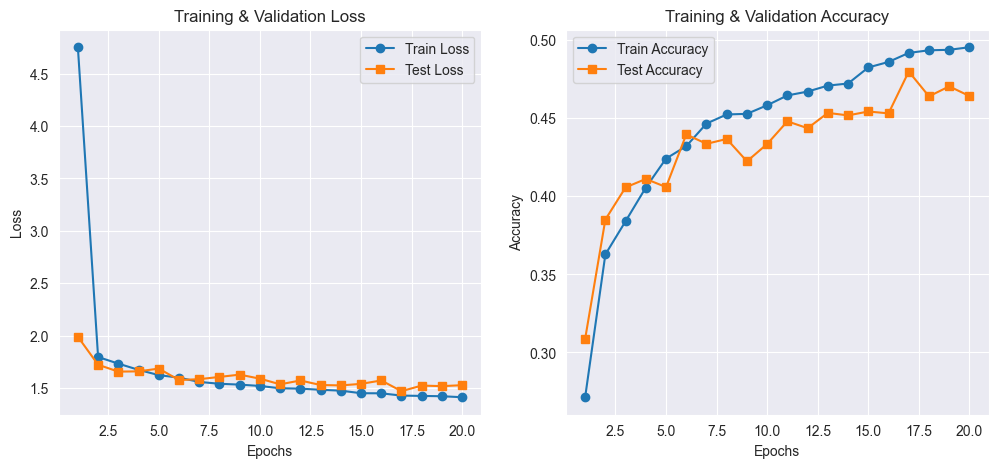

In [7]:
plt.figure(figsize=(12, 5))

# 绘制 Loss 曲线
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss', marker='o')
plt.plot(range(1, num_epochs + 1), test_losses, label='Test Loss', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training & Validation Loss")

# 绘制 Accuracy 曲线
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy', marker='o')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy', marker='s')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training & Validation Accuracy")

plt.show()

Precision: 0.4873, Recall: 0.4642, F1: 0.4542


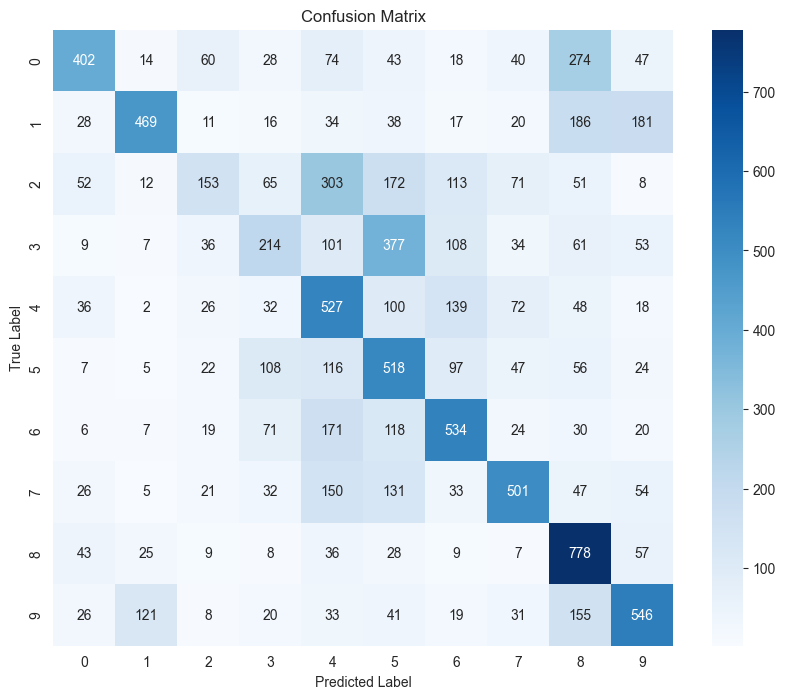

In [8]:
def compute_metrics(model, loader):
    model.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    precision = precision_score(all_labels, all_preds, average='macro')
    recall = recall_score(all_labels, all_preds, average='macro')
    f1 = f1_score(all_labels, all_preds, average='macro')
    cm = confusion_matrix(all_labels, all_preds)
    
    return precision, recall, f1, cm

# 计算最终结果
precision, recall, f1, cm = compute_metrics(model, test_loader)

# 输出指标
print(f"Precision: {precision:.4f}, Recall: {recall:.4f}, F1: {f1:.4f}")

# 绘制 Confusion Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=range(10), yticklabels=range(10))
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()